# ビジネス時系列分析のためのProphetとNeuralProphetの理論と応用



# ライブラリのインストール

In [ ]:
#!pip install prophet
#!pip install neuralprophet

#ライブラリのインポート

In [ ]:
# データ整形ライブラリ
import pandas as pd
import numpy as np

# 統計モデルライブラリ
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# 可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# ProphetとNeuralProphet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from neuralprophet import NeuralProphet

# Prophetモデル
* ここでは，WikipediaのPeyton Manning（アメリカンフットボールの元選手）のページの日時のページビューのデータを取り上げ，Prophetのモデル設定が予測精度などにどのような影響を与えるか確かめる．
* Prophetでは，データは`pandas.DataFrame`形式を使用し，日付は ` 'ds' `，予測変数は` 'y'`と名前の付いた列に用意する必要がある．

In [ ]:
# データの読み込み
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv', parse_dates=['ds'])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


<AxesSubplot: xlabel='ds'>

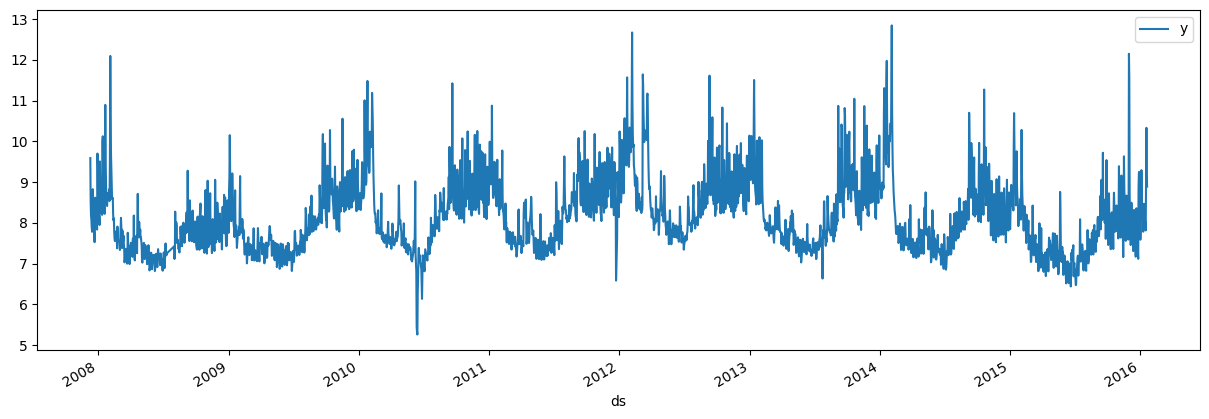

In [ ]:
# 可視化
df.plot(y='y', x='ds', figsize=(15,5))

In [ ]:
# 訓練データとテストデータに分ける
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

## Prophetモデル設定
1. ベースライン：とりあえず何も考えすにデフォルトで推定してみる
1. 変化点に関する事前分布`changepoint_prior_scale`を変更
1. モデル1+`monthly_seasonality`
1. モデル1の`yearly_seasonality`のフーリエオーダーを変更
1. モデル1の`seasonality_mode`を`multiplicative`にする
1. モデル1+祝日効果
1. モデル6+アメリカンフットボールのイベント効果

## Prophet モデル1
ベースラインモデル：`Prophet`でパラメータを特に指定せずすべてデフォルト値を使う

In [ ]:
# モデル1をフィット
m1 = Prophet()
m1.fit(df_train)

# 予測：ここでadditive_terms = weekly + yearly
f1 = m1.predict(df)
print(f1.tail())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from

Initial log joint probability = -13.3195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7167.44      0.011985       825.171      0.3582           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7181.04    0.00208899       233.414           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7189.04    0.00195435       122.678      0.8967      0.8967      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7192.32   0.000287794       101.737      0.6498      0.6498      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7194.69    0.00170861        532.71      0.3441           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

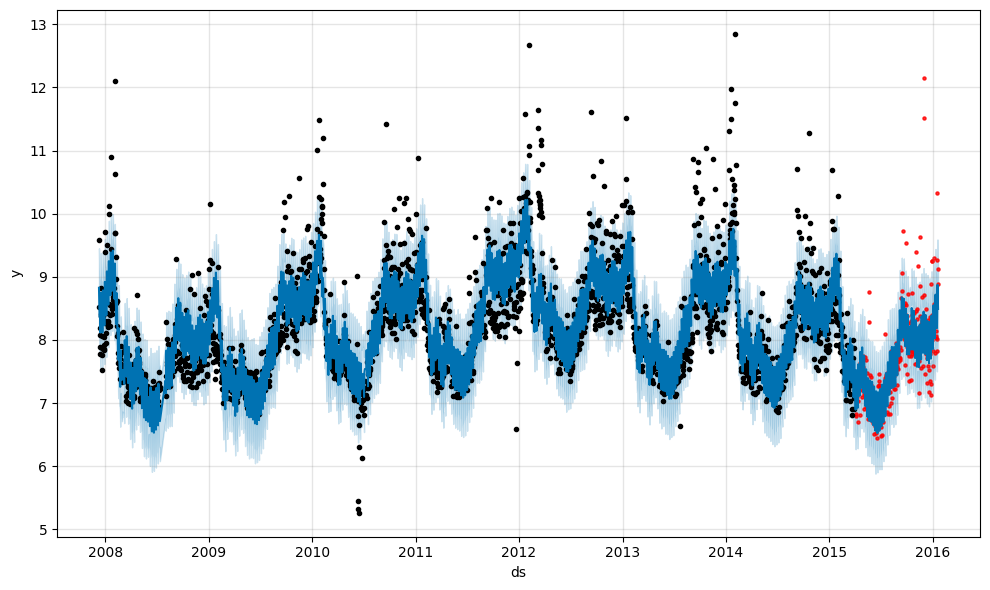

In [ ]:
# 推定・予測結果の可視化
fig11 = m1.plot(f1)

# テストデータ内の観測値を赤点で表示
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')


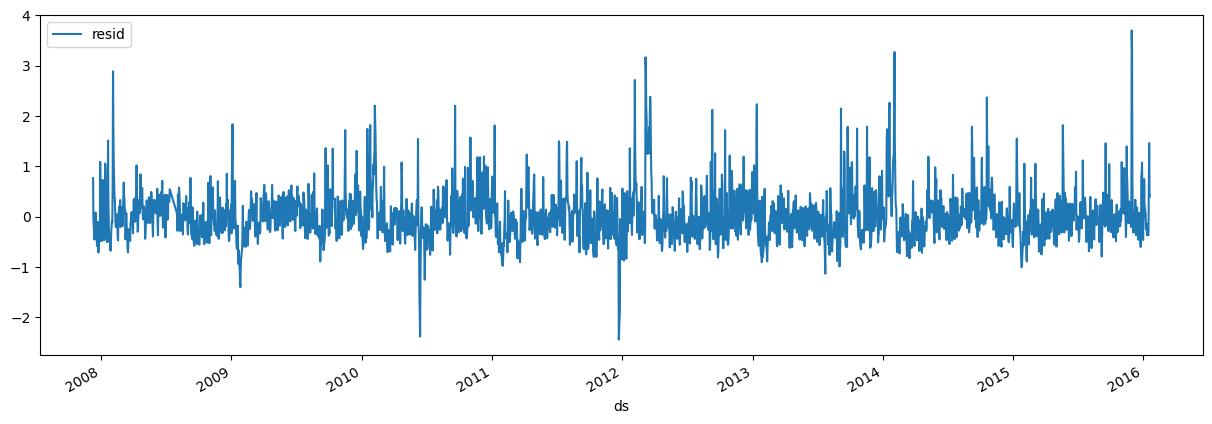

In [ ]:
# 残差・予測誤差
f1['resid'] = df.y - f1.yhat
fig12 = f1.plot(y='resid', x='ds', figsize=(15,5))


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



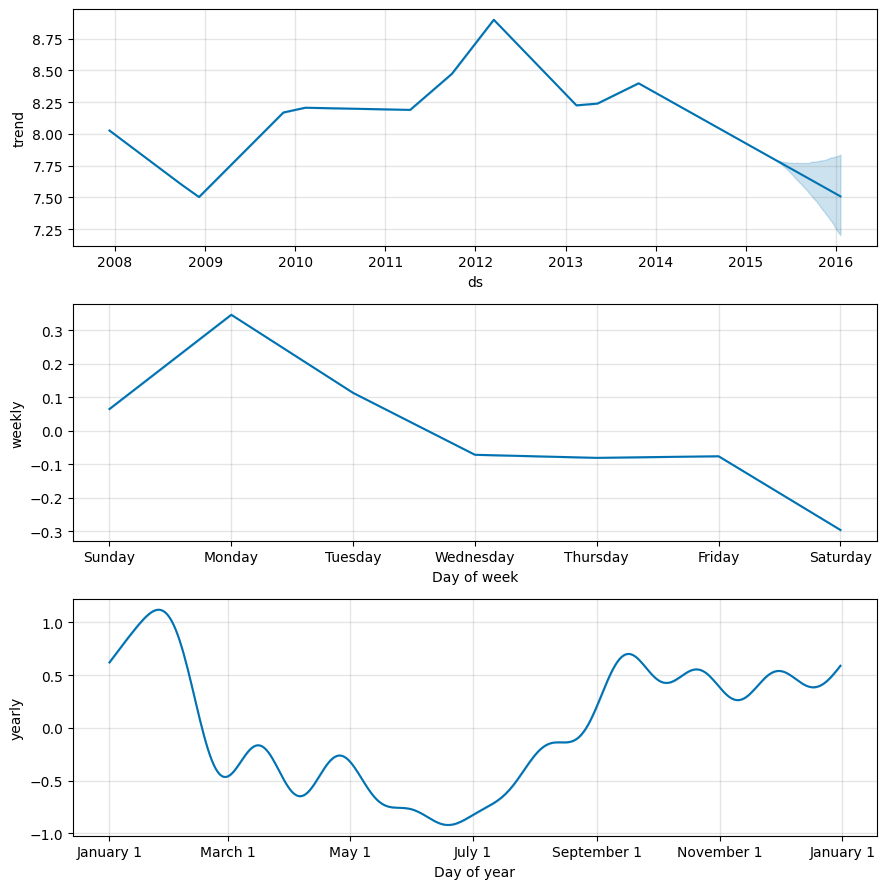

In [ ]:
# 各コンポネントの可視化
fig13 = m1.plot_components(f1)

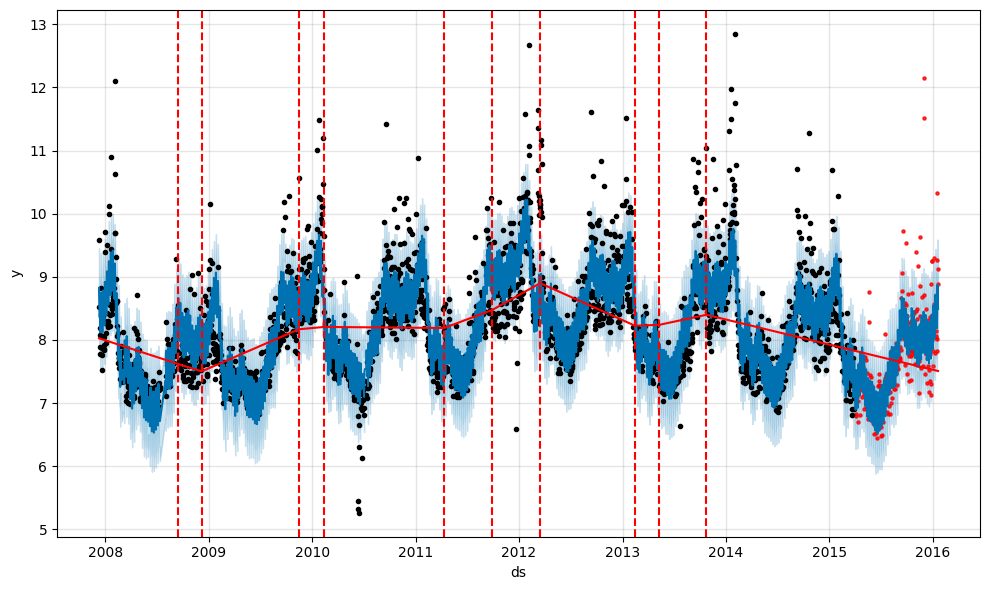

In [ ]:
# 変化点も可視化する
fig14 = m1.plot(f1)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')
a1 = add_changepoints_to_plot(fig14.gca(), m1, f1)

In [ ]:
# 平均絶対予測誤差
def myMAE(yhat, y):
  return np.mean(np.abs(yhat-y))

print(myMAE(f1.yhat, df_test.y))

0.2907777973412221


## Prophet モデル2
* 変化点に関する事前分布`changepoint_prior_scale`の設定をデフォルトの0.05から0.5に変える
* 変化を許容しやすくするため変化点の数が増える
* より柔軟になる可能性もあるが過適合の危険性もある

In [ ]:
# モデル1をフィット
m2 = Prophet(changepoint_prior_scale=0.5)
m2.fit(df_train)

# 予測：ここでadditive_terms = weekly + yearly
f2 = m2.predict(df)
#print(f2.tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from

Initial log joint probability = -13.3195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7221.94    0.00593938       508.012           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7265.91   0.000663773       250.938      0.2831      0.2831      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7286.9     0.0576758       1080.48           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7302.76     0.0193924        512.68      0.9435      0.9435      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7319.95    0.00132973       1057.58     0.08174           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



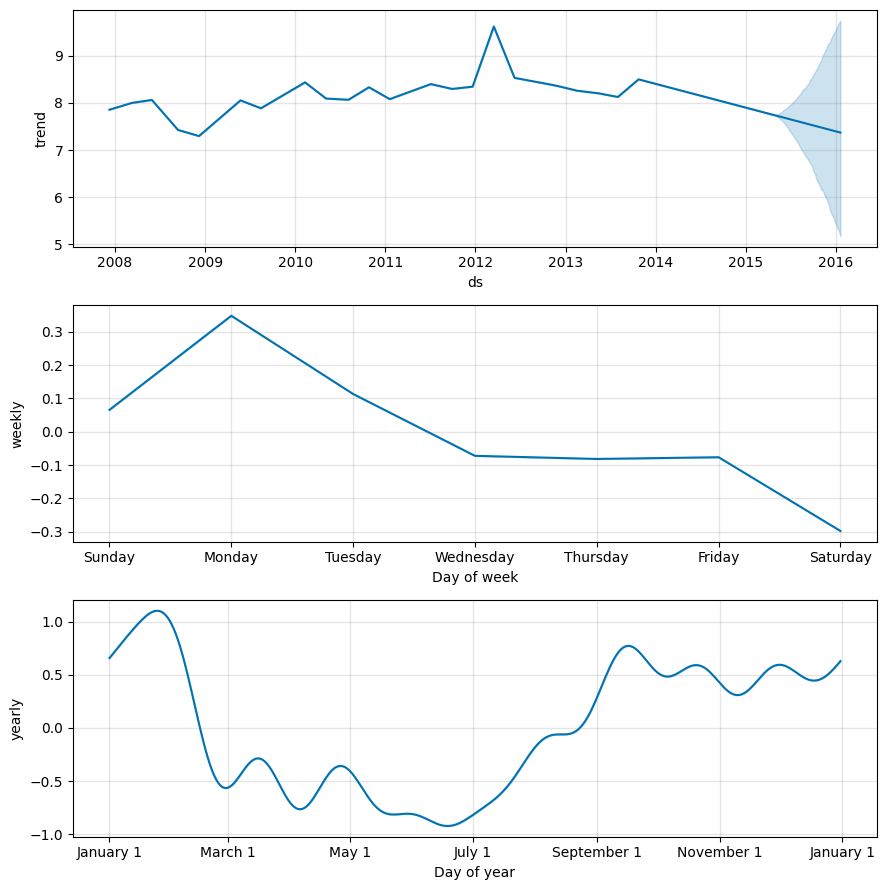

In [ ]:
# 各コンポネントの可視化
fig21 = m2.plot_components(f2)

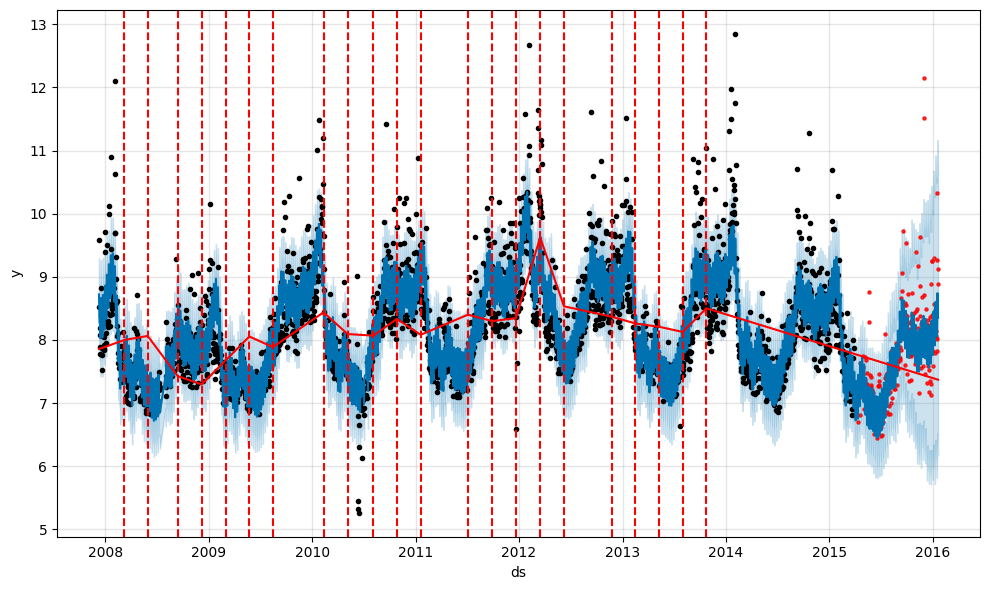

In [ ]:
# 変化点を可視化する
fig21 = m1.plot(f2)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')
a2 = add_changepoints_to_plot(fig21.gca(), m2, f2)

In [ ]:
# 平均絶対予測誤差
print(myMAE(f2.yhat, df_test.y))

0.2997051923593361


## Prophet モデル3
* 1ヶ月の周期性を追加する
* `add_seasonality'メソッドを使用
* 周期`period`は30.5，`fourier_order`は5としておく

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -13.3195


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7175.16     0.0860635       1854.66           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7194.82    0.00352491        136.66           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7202.88   0.000626898       165.296           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7206.26   0.000666608       154.908      0.8676      0.8676      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     461       7207.71   0.000117001       256.122   7.342e-07       0.001      602  LS failed, Hessian reset 
     499        7209.4    0.00179336       174.766           1           1      6

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



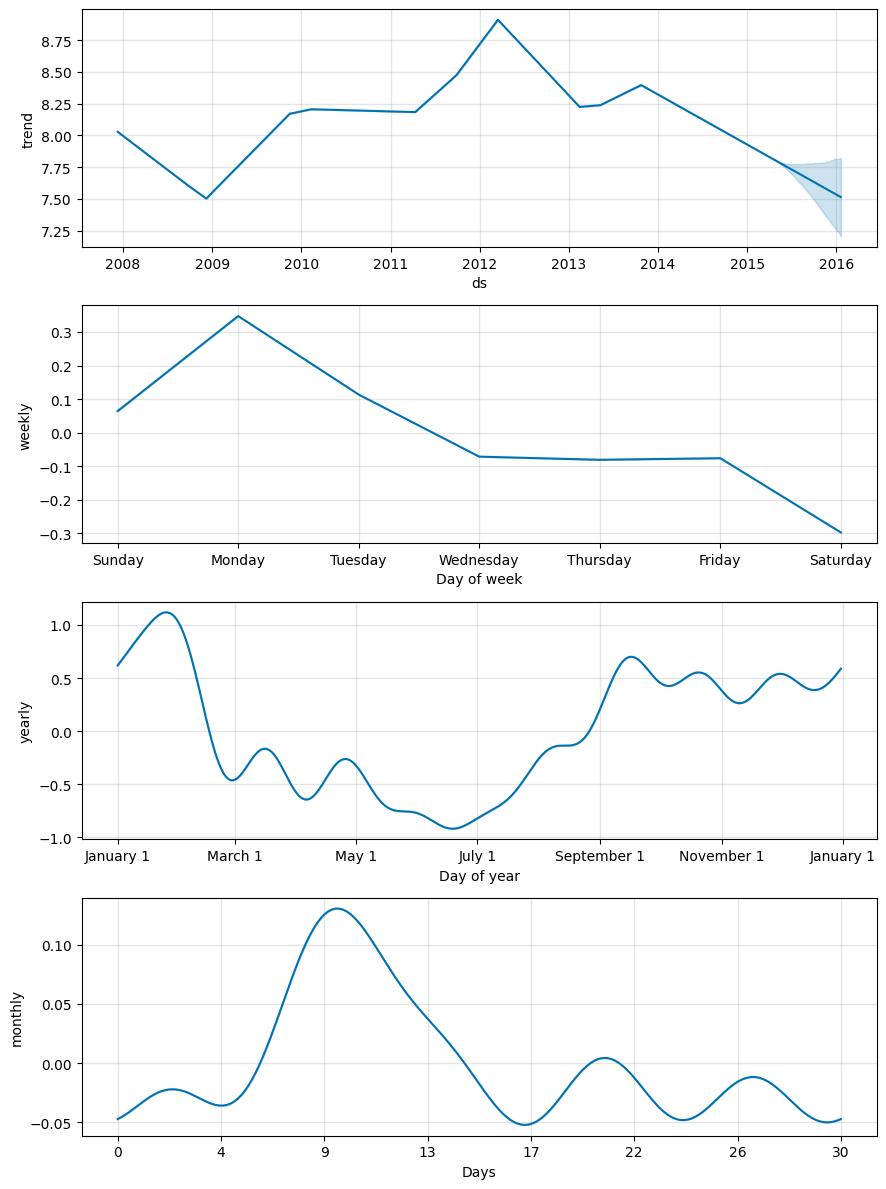

In [ ]:
m3 = Prophet()
m3.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m3.fit(df_train)
f3 = m3.predict(df)

# コンポネントを可視化：月次の周期性も追加されている
fig31 = m3.plot_components(f3)

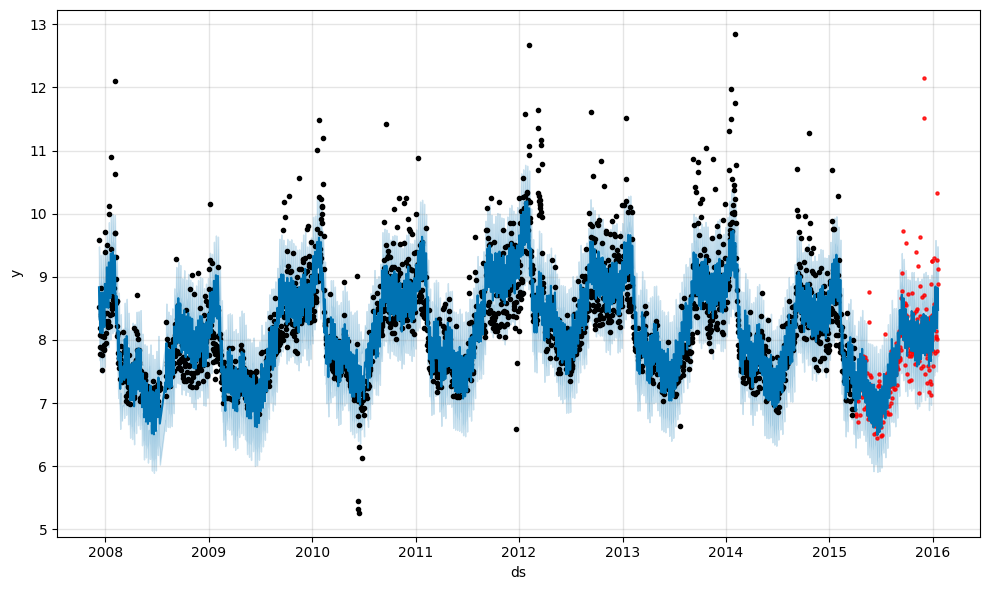

In [ ]:
# 結果の可視化
fig32 = m3.plot(f3)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')

In [ ]:
# 平均絶対予測誤差
print(myMAE(f3.yhat, df_test.y))

0.2974786990333124


## Prophet モデル4
* 1年の周期性の`fourier_order`を変更する
* デフォルトでは1週間周期は3，1年周期は10

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -13.3195


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7214.21    0.00143652       428.294           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7227.86    0.00448464        916.64           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7238.44     0.0155285       973.891           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       7241.92   4.63559e-05       122.642   4.109e-07       0.001      509  LS failed, Hessian reset 
     399       7241.97   0.000712576       231.881           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       7242.52   6.65063e-05       193.705   3.392e-07       0.001      6

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



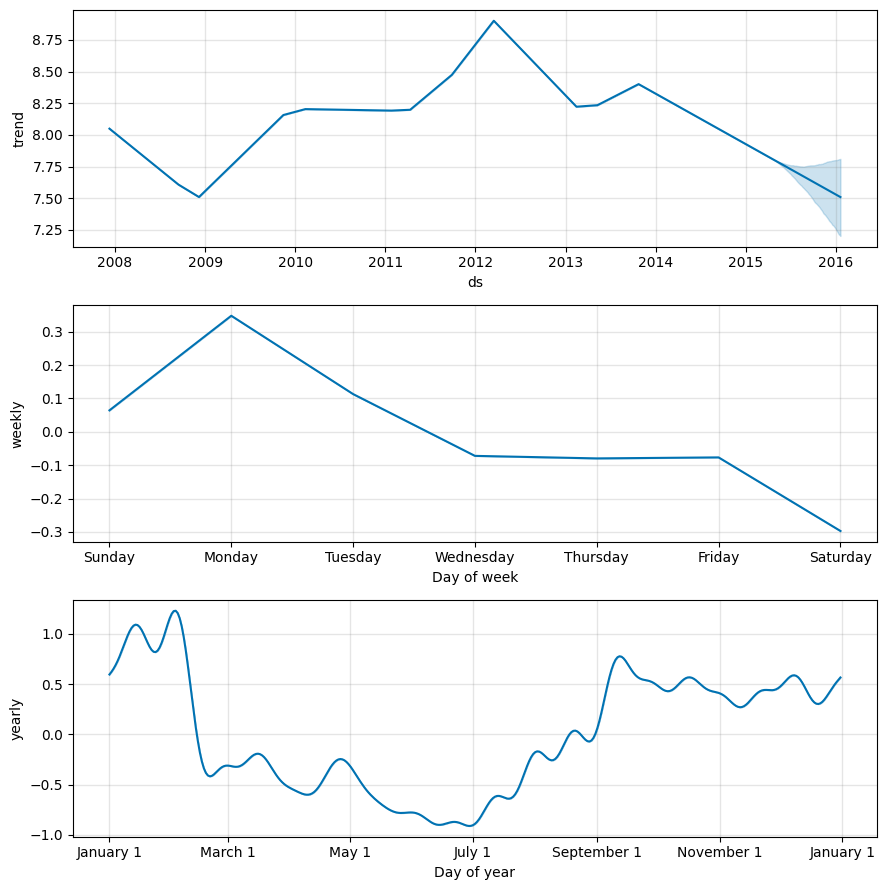

In [ ]:
m4 = Prophet(yearly_seasonality=20)
m4.fit(df_train)
f4 = m4.predict(df)

# コンポネントを可視化：月次の周期性も追加されている
fig41 = m4.plot_components(f4)

In [ ]:
# 平均絶対予測誤差
print(myMAE(f4.yhat, df_test.y))

0.2953997338461661


## Prophet モデル5
* 周期性をデフォルトの加法`additive`から乗法`multiplicative`にする

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -13.3195


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7176.28    0.00191484       984.451      0.5582      0.5582      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7195.13    0.00224481       659.557      0.3353      0.3353      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7202.1    0.00220792       149.246           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7205.14   0.000404579       275.274       0.277       0.277      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     473       7206.91   3.35054e-05       93.0851   2.048e-07       0.001      643  LS failed, Hessian reset 
     499       7208.14    0.00123143       163.977           1           1      6

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



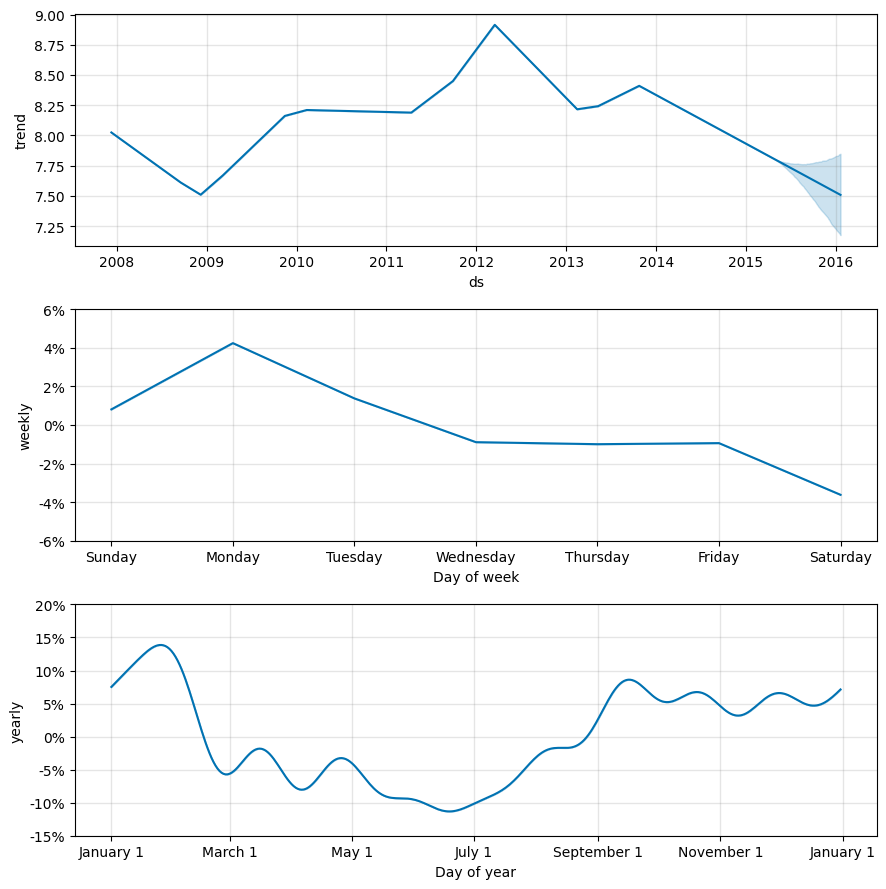

In [ ]:
m5 = Prophet(seasonality_mode='multiplicative')
m5.fit(df_train)
f5 = m5.predict(df)

fig51 = m5.plot_components(f5)

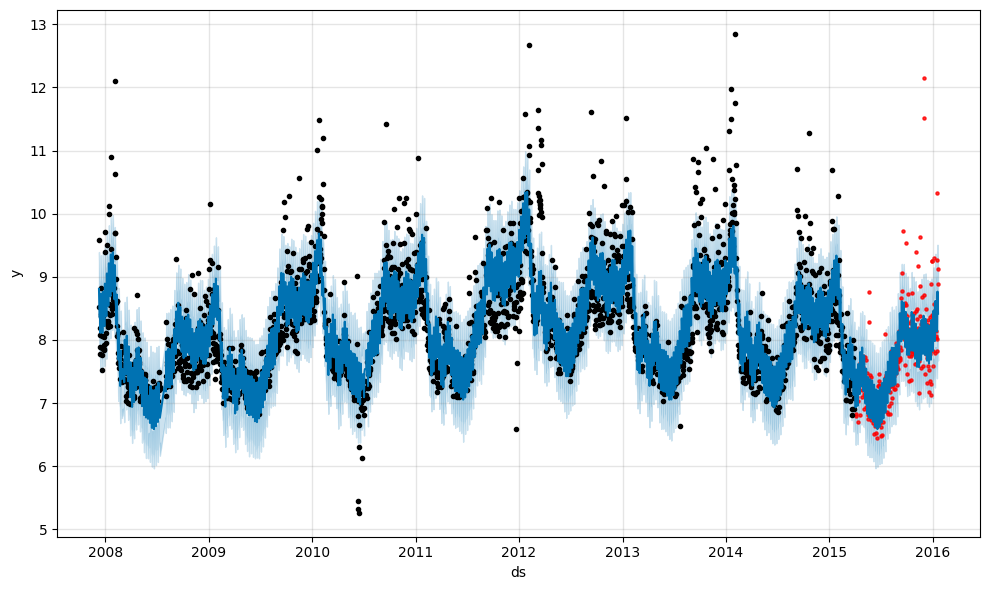

In [ ]:
# 結果の可視化
fig52 = m5.plot(f5)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')

In [ ]:
# 平均絶対予測誤差
print(myMAE(f5.yhat, df_test.y))

0.292335697415188


## Prophet モデル6
* 祝日の効果を考慮
* 'add_country_holidays'でアメリカの祝日を追加

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -13.3195


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7190.12    0.00365732       683.393           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7206.32    0.00149359       352.461           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7215.12   0.000689125       111.992           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7221.01    0.00135728         369.7           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412        7221.4   4.43809e-05       111.018   7.699e-07       0.001      533  LS failed, Hessian reset 
     484       7222.74   5.90212e-05       168.787   2.968e-07       0.001      6

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



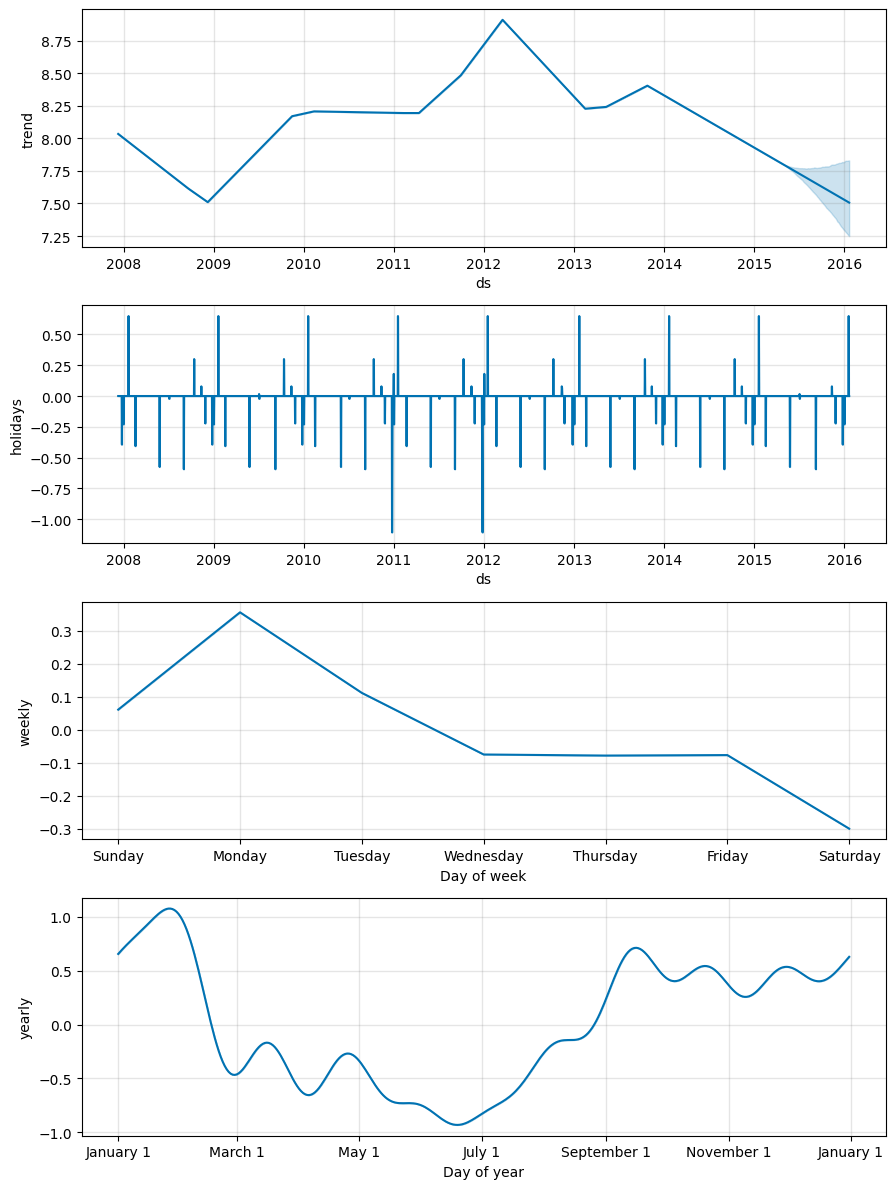

In [ ]:
m6 = Prophet()
m6.add_country_holidays('US')
m6.fit(df_train)
f6 = m6.predict(df)

# コンポネントの可視化：祝日の効果が追加されている
fig61 = m6.plot_components(f6)


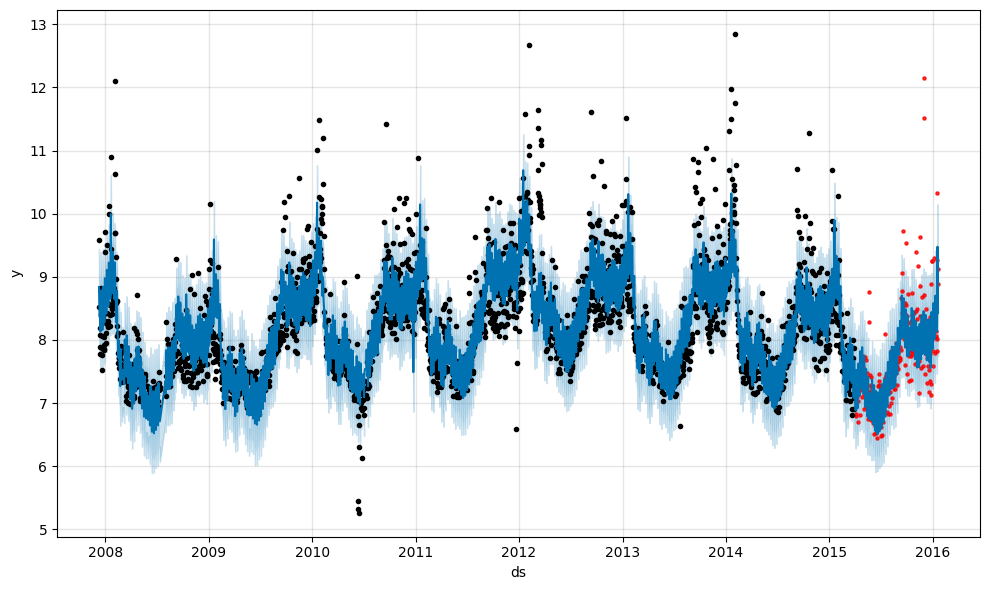

In [ ]:
# 結果の可視化
fig62 = m6.plot(f6)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')

In [ ]:
# 平均絶対予測誤差
print(myMAE(f6.yhat, df_test.y))

0.28313470306496374


## Prophet モデル7
* モデル6にアメリカンフットボールのイベント（スーパーボウル，プレーオフ）の効果も追加
* それぞれの日にちを`pd.DataFrame`で指定する

In [ ]:
# プレーオフの日付
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
# スーパーボウルの日付
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
# ひとつのデータフレームにまとめる
football = pd.concat((playoffs, superbowls))

In [ ]:
football

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



Initial log joint probability = -13.3195


WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7338.34    0.00262064       323.653           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7353.25     0.0178188        748.48           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7363.7   0.000294262       93.2031      0.2928      0.2928      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       7366.04   0.000100102       181.704   1.567e-07       0.001      450  LS failed, Hessian reset 
     399       7368.71    0.00174151       287.877           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       7370.63   7.71426e-05       256.952    2.59e-07       0.001      6

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - /Users/boostudio/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



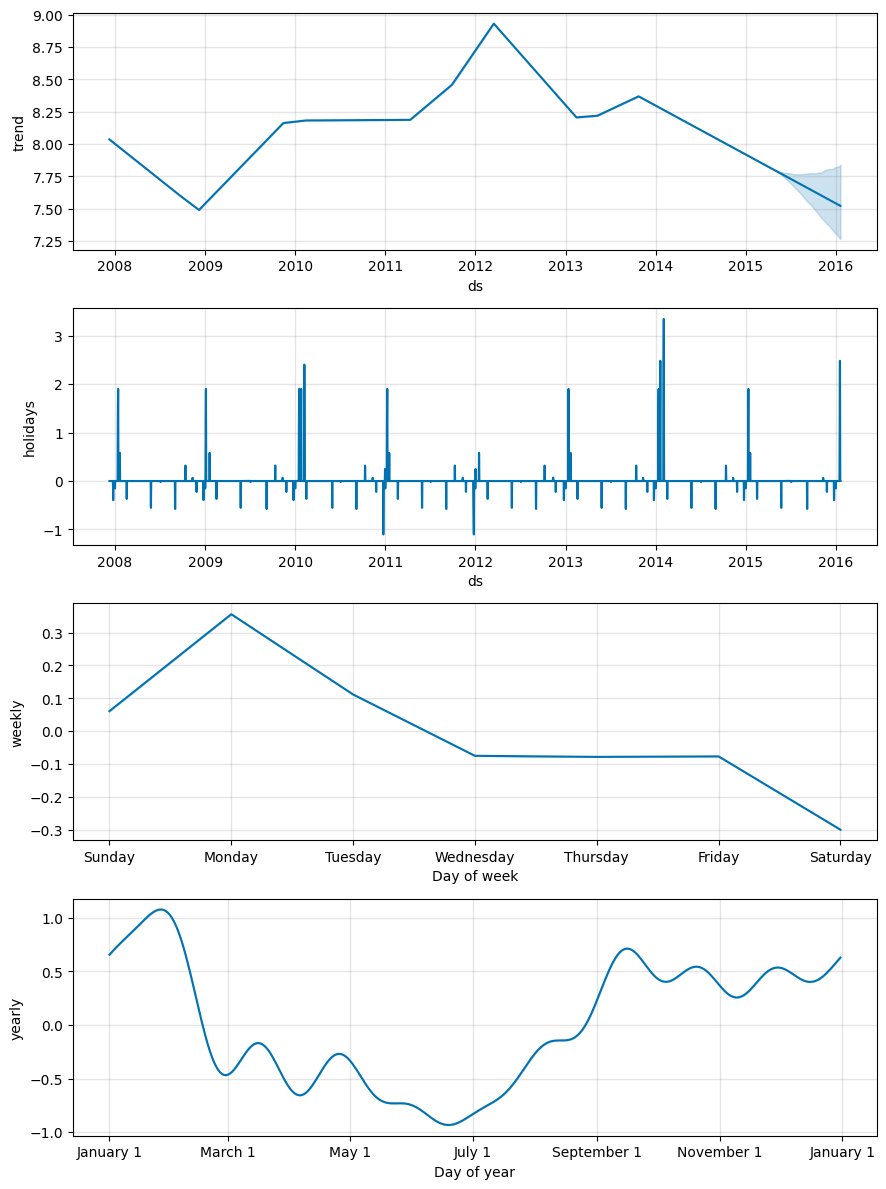

In [ ]:
m7 = Prophet(holidays=football)
m7.add_country_holidays('US')

m7.fit(df_train)
f7 = m7.predict(df)

fig71 = m6.plot_components(f7)


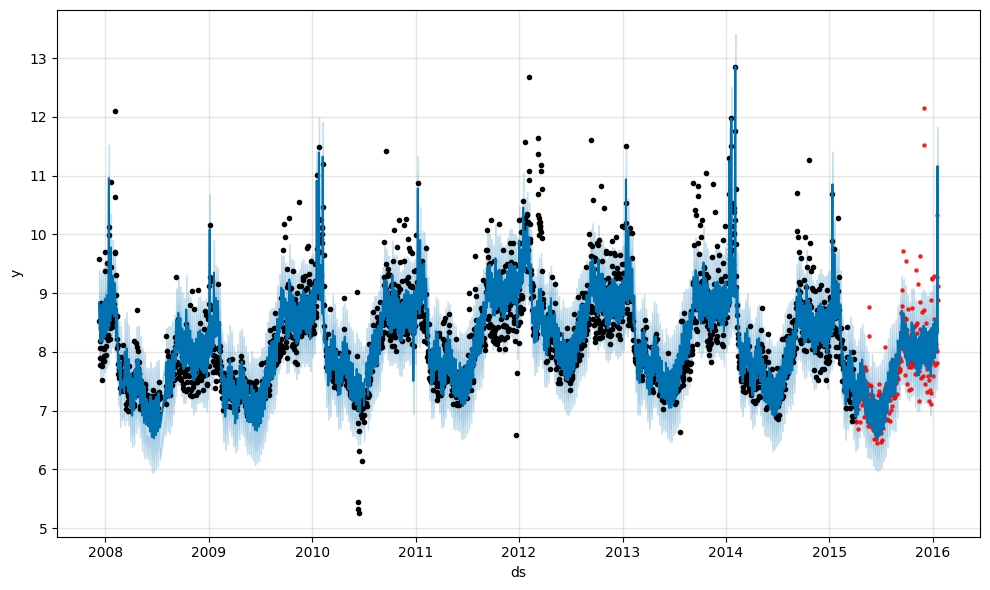

In [ ]:
# 結果の可視化
fig72 = m7.plot(f7)
plt.scatter(y=df_test.y, x=df_test.ds, s=5, marker='o', alpha=0.8, color='red')

In [ ]:
# 平均絶対予測誤差
print(myMAE(f7.yhat, df_test.y))

0.2789732665985307


# NeuralProphetモデル
* 引き続きWikipediaページのページビューのデータを取り扱う

In [ ]:
# プレーオフの日付
playoffs = pd.DataFrame({
  'event': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
# スーパーボウルの日付
superbowls = pd.DataFrame({
  'event': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
# ひとつのデータフレームにまとめる
football = pd.concat((playoffs, superbowls))

In [ ]:
football

,event,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


## NeuralProphetモデル設定
1. デフォルトの設定+祝日・イベント効果
1. AR-Netを追加

# NeuralProphet モデル1
* デフォルトの設定+モデル7のように祝日・イベント効果で推定してみる
* ほぼProphetと同じ

In [ ]:
m8 = NeuralProphet()
m8.set_plotting_backend('matplotlib')
m8.add_country_holidays('US')
m8.add_events(['playoff', 'superbowl'])
df_events = m8.create_df_with_events(df, football)
df_events_train, df_events_test = train_test_split(df_events, test_size=0.1, shuffle=False)
met8 = m8.fit(df_events_train, freq='D')

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.891% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.891% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO 

Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# 予測用のデータフレームを作成：10日先までの予測を行う
TT = 10
df_future8 = m8.make_future_dataframe(df_events_train, periods=TT, n_historic_predictions=df_events_train.shape[0])
f8 = m8.predict(df_future8)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.891% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.891% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.data.splitting._make_future_dataframe) - Future values not supplied for user specified events. All events being treated as not occurring in future
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.895% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.895% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corres

Predicting: 82it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
df_test.ds[:TT]

WARNING - (py.warnings._showwarnmsg) - /var/folders/js/l3lb9hld0sx1s9lx8gvjclnm0000gn/T/ipykernel_17741/310192426.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_test.ds[:TT]

  df_test.ds[:TT]



2614   2015-04-04
2615   2015-04-05
2616   2015-04-06
2617   2015-04-07
2618   2015-04-08
2619   2015-04-09
2620   2015-04-10
2621   2015-04-11
2622   2015-04-12
2623   2015-04-13
Name: ds, dtype: datetime64[ns]

In [ ]:
f8.tail(10)

,ds,y,yhat1,trend,season_yearly,season_weekly,events_additive,event_Christmas Day,event_Christmas Day (Observed),event_Columbus Day,...,event_Martin Luther King Jr. Day,event_Memorial Day,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday,event_playoff,event_superbowl
2614,2015-04-04,NaN,7.173319,7.936197,-0.451044,-0.311834,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,2015-04-05,NaN,7.521041,7.935607,-0.452677,0.038111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,2015-04-06,NaN,7.858992,7.935017,-0.454808,0.378782,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2617,2015-04-07,NaN,7.594959,7.934427,-0.457414,0.117946,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2618,2015-04-08,NaN,7.397112,7.933837,-0.460466,-0.076259,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2619,2015-04-09,NaN,7.396075,7.933248,-0.463927,-0.073245,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2620,2015-04-10,NaN,7.391401,7.932657,-0.467756,-0.073500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2621,2015-04-11,NaN,7.148322,7.932067,-0.471911,-0.311834,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2622,2015-04-12,NaN,7.493244,7.931477,-0.476344,0.038111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2623,2015-04-13,NaN,7.828664,7.930887,-0.481005,0.378782,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /var/folders/js/l3lb9hld0sx1s9lx8gvjclnm0000gn/T/ipykernel_17741/4018485804.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')

  plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')



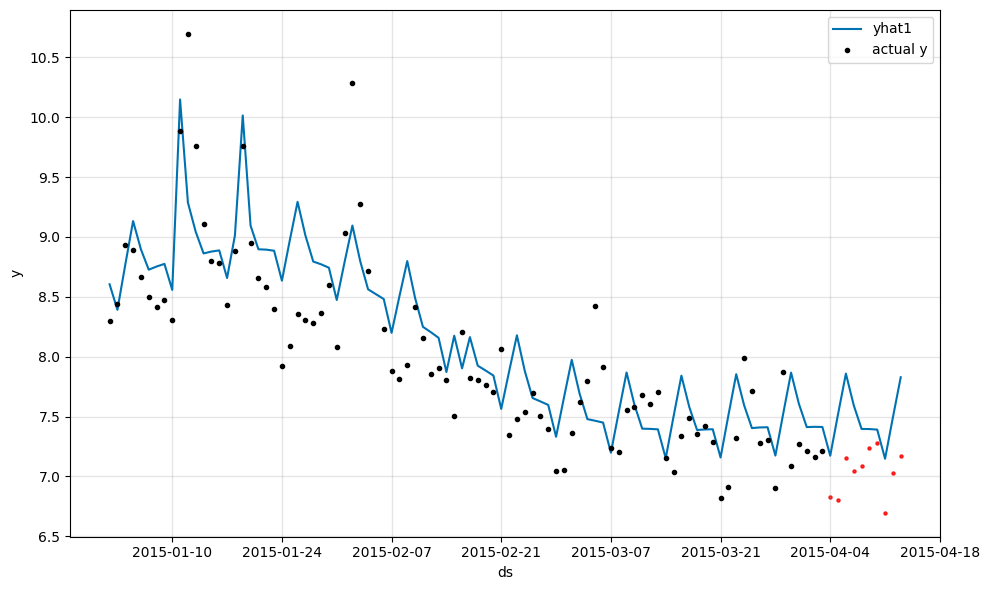

In [ ]:
fig81 = m8.plot(f8[f8.ds>pd.to_datetime("2015-01-01")])
plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


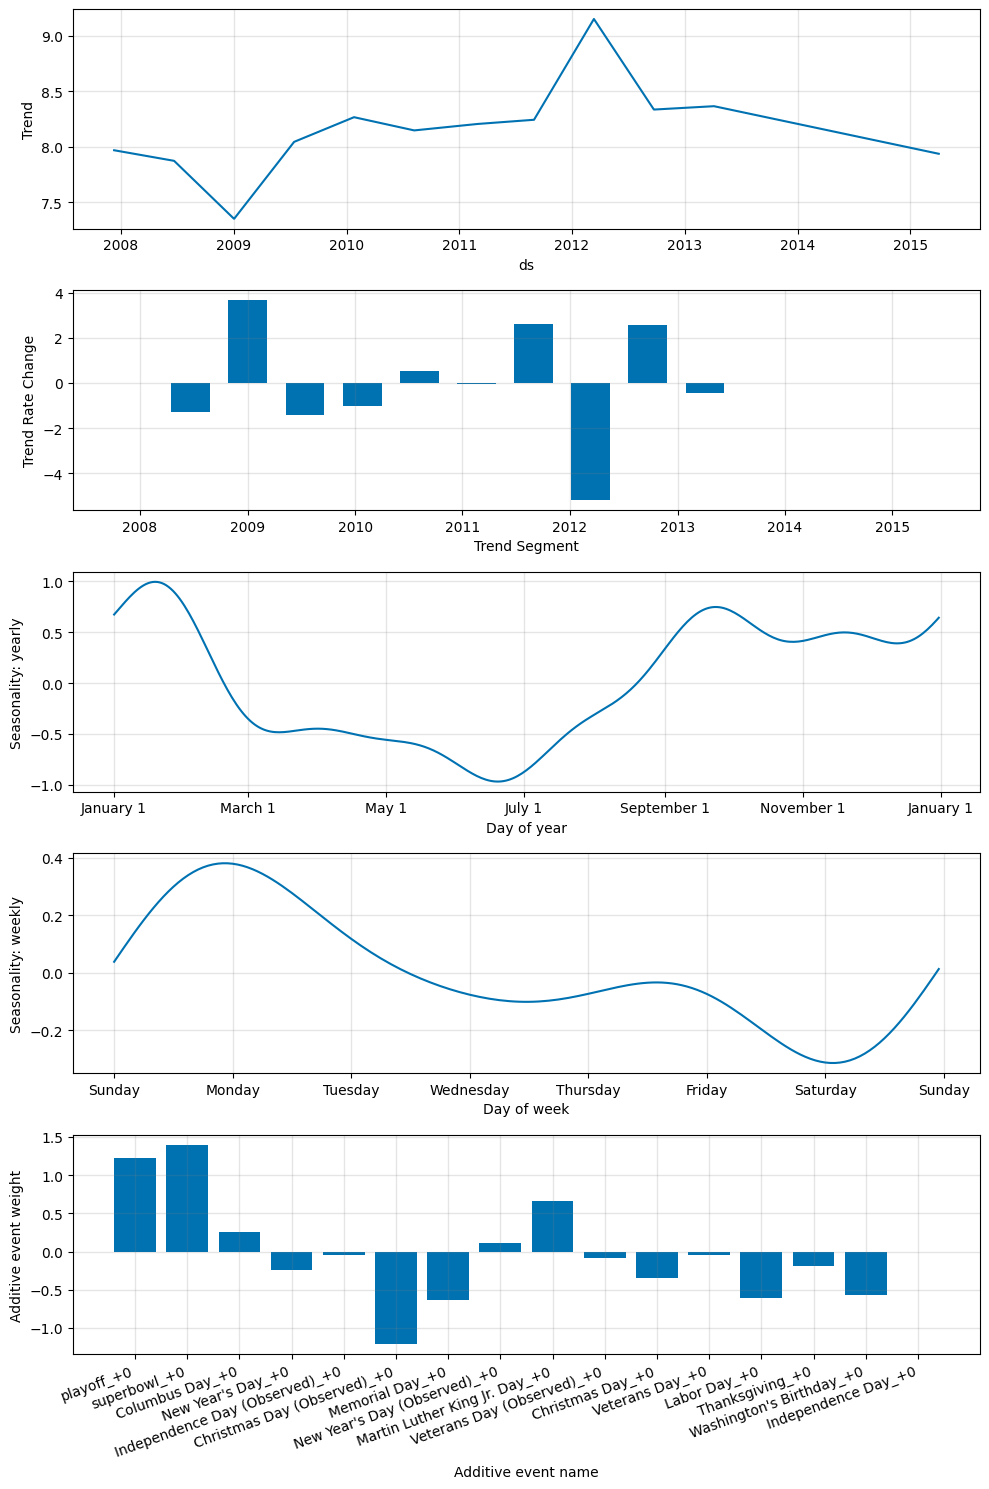

In [ ]:
m8.plot_parameters()

## Neural Prophet モデル2
* AR-Netの項を追加，ARのオーダー`n_lags`は15

In [ ]:
m9 = NeuralProphet(n_lags=15, n_forecasts=TT)
m9.set_plotting_backend('matplotlib')
m9.add_country_holidays('US')
m9.add_events(['playoff', 'superbowl'])
df_events = m9.create_df_with_events(df, football)
df_events_train, df_events_test = train_test_split(df_events, test_size=0.1, shuffle=False)
met9 = m9.fit(df_events_train, freq='D')


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.891% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.891% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data_single_id) - 58 missing dates added.
INFO:NP.data.processing:58 missing dates added.
WARNING - (NP.data.processing._handle_missing_data_single_id) - 58 missing valu

Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
df_future9 = m9.make_future_dataframe(df_events_train, periods=TT, n_historic_predictions=df_events_train.shape[0])
f9 = m9.predict(df_future9)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.891% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.891% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.data.splitting._make_future_dataframe) - Insufficient data for 2614 historic forecasts, reduced to 2599.
WARNING - (NP.data.splitting._make_future_dataframe) - Future values not supplied for user specified events. All events being treated as not occurring in future
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.895% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.895% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_u

Predicting: 83it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
# 予測結果
f9.iloc[:,:12].tail(30)

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,yhat10
2652,2015-03-15,7.040536,7.311280,7.371162,7.335022,7.357849,7.345408,7.329308,7.337197,7.347339,7.449854,7.475906
2653,2015-03-16,7.338888,7.462033,7.619830,7.661354,7.637250,7.659622,7.640759,7.614124,7.624656,7.585579,7.670485
2654,2015-03-17,7.484369,7.383304,7.478546,7.569794,7.598849,7.572685,7.590948,7.563667,7.554448,7.562094,7.506872
2655,2015-03-18,7.351800,7.498628,7.490895,7.552210,7.613230,7.631341,7.608255,7.630164,7.611675,7.619333,7.623156
2656,2015-03-19,7.423568,7.523277,7.626775,7.636566,7.677410,7.727102,7.731222,7.701217,7.728855,7.725791,7.741218
2657,2015-03-20,7.291656,7.442227,7.527455,7.593529,7.599465,7.628598,7.661202,7.654467,7.621705,7.640639,7.647433
2658,2015-03-21,6.816736,7.021235,7.035644,7.093440,7.137698,7.133181,7.142533,7.173409,7.198009,7.179959,7.188053
2659,2015-03-22,6.910751,7.135460,7.214555,7.203130,7.241424,7.276173,7.252309,7.252427,7.320537,7.355076,7.351912
2660,2015-03-23,7.321189,7.408201,7.518736,7.553275,7.546365,7.573815,7.585824,7.543776,7.582092,7.642342,7.672970
2661,2015-03-24,7.991592,7.334918,7.391860,7.449996,7.473897,7.482923,7.487853,7.490484,7.482417,7.529064,7.565409


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles
WARNING - (py.warnings._showwarnmsg) - /var/folders/js/l3lb9hld0sx1s9lx8gvjclnm0000gn/T/ipykernel_17741/468729437.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')

  plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')



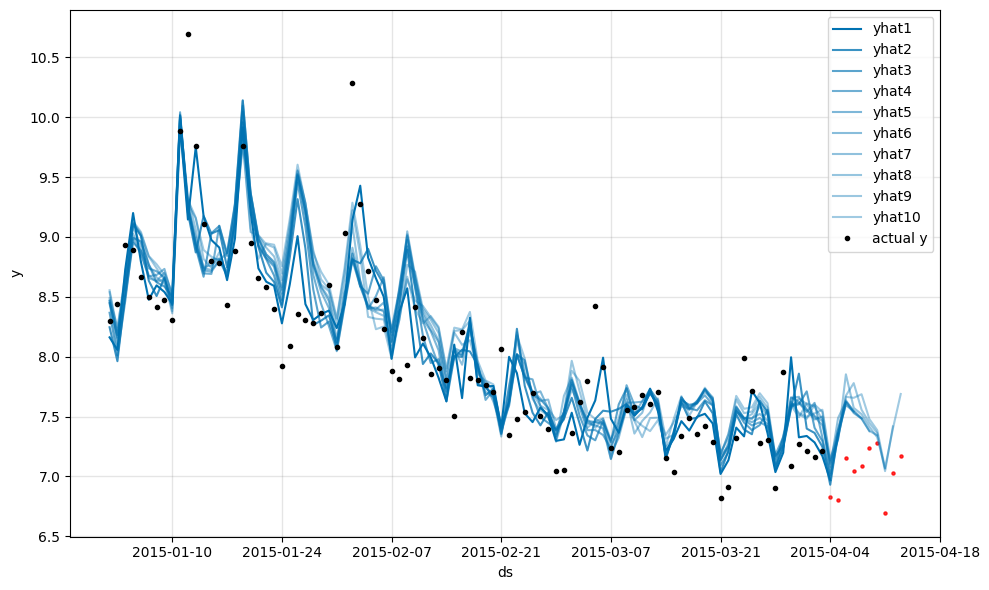

In [ ]:
# 結果を可視化
fig91 = m9.plot(f9[f9.ds>pd.to_datetime("2015-01-01")])
plt.scatter(y=df_test.y[:TT], x=df_test.ds[:TT], s=5, marker='o', alpha=0.8, color='red')